<a href="https://colab.research.google.com/github/aifajar/eratani_ml_path/blob/main/Forecast_model_for_Tx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
url = '/content/df_Tx.csv'

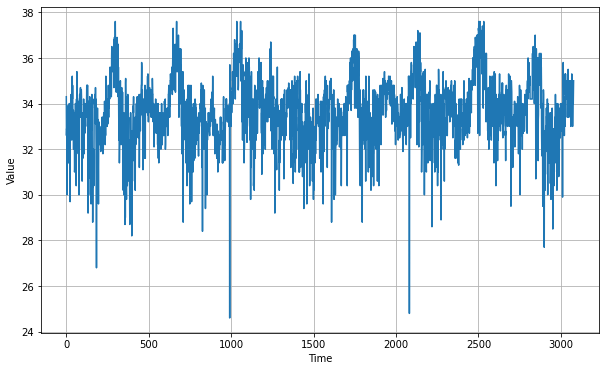

In [4]:
import csv
time_step = []
temps = []

with open(url) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2300
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2300,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 [==============================] - 6s 298ms/step - loss: 48.2426 - mae: 48.7414
Epoch 2/100
9/9 [==============================] - 3s 294ms/step - loss: 46.4529 - mae: 46.9510
Epoch 3/100
9/9 [==============================] - 3s 290ms/step - loss: 43.4284 - mae: 43.9257
Epoch 4/100
9/9 [==============================] - 3s 290ms/step - loss: 39.1072 - mae: 39.6046
Epoch 5/100
9/9 [==============================] - 3s 292ms/step - loss: 33.2269 - mae: 33.7235
Epoch 6/100
9/9 [==============================] - 3s 292ms/step - loss: 26.7861 - mae: 27.2831
Epoch 7/100
9/9 [==============================] - 3s 292ms/step - loss: 21.3305 - mae: 21.8271
Epoch 8/100
9/9 [==============================] - 3s 294ms/step - loss: 16.4220 - mae: 16.9194
Epoch 9/100
9/9 [==============================] - 3s 291ms/step - loss: 12.0775 - mae: 12.5747
Epoch 10/100
9/9 [==============================] - 3s 291ms/step - loss: 8.1450 - mae: 8.6412
Epoch 11/100
9/9 [=======================

(1e-08, 0.0001, 0.0, 60.0)

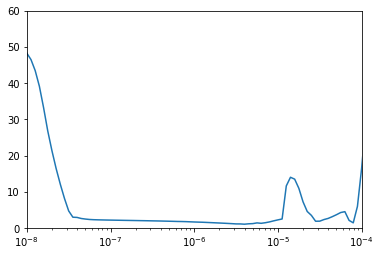

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
23/23 [==============================] - 6s 111ms/step - loss: 7.2388 - mae: 7.7183
Epoch 2/150
23/23 [==============================] - 3s 111ms/step - loss: 2.0212 - mae: 2.4920
Epoch 3/150
23/23 [==============================] - 3s 111ms/step - loss: 0.9178 - mae: 1.3366
Epoch 4/150
23/23 [==============================] - 3s 110ms/step - loss: 0.7990 - mae: 1.2071
Epoch 5/150
23/23 [==============================] - 3s 110ms/step - loss: 0.7482 - mae: 1.1530
Epoch 6/150
23/23 [==============================] - 3s 110ms/step - loss: 0.6460 - mae: 1.0373
Epoch 7/150
23/23 [==============================] - 3s 109ms/step - loss: 0.6703 - mae: 1.0657
Epoch 8/150
23/23 [==============================] - 3s 110ms/step - loss: 0.6764 - mae: 1.0731
Epoch 9/150
23/23 [==============================] - 3s 111ms/step - loss: 0.5994 - mae: 0.9848
Epoch 10/150
23/23 [==============================] - 3s 111ms/step - loss: 0.5907 - mae: 0.9755
Epoch 11/150
23/23 [===================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

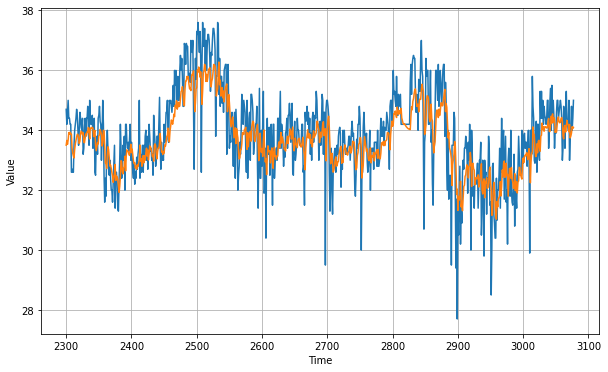

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.7707842

In [14]:
for n in range(28):
  print(rnn_forecast[n])

33.501617
33.661617
33.530098
33.68167
33.921623
33.870197
33.93535
33.870686
33.87177
33.416332
33.233536
33.143734
33.07514
33.360325
33.541767
33.67368
33.783146
33.86802
33.85978
33.748127
33.56074
33.637913
33.881657
33.969963
33.9477
33.855133
33.920227
33.609028
